In [1]:
import numpy as np
from math import pi, log
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from scipy.stats import wilcoxon

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

##### Declaring global variables

In [2]:
global seed
global call_counter
call_counter = [0, 0, 0, 0, 0, 0, 0, 0]
seed = 42 # To make results repeatable.

# Defining functions

#### Parameters defined through function of decision vector x

In [3]:
def W(x):
    """
    Load carrying capacity
    """
    return (pi * P0(x)/2) * ((x[2] ** 2 - x[1] ** 2)/log(x[2]/x[1]))

def P0(x):
    """
    Inlet pressure
    """
    return ((6e-6 * x[3] * x[0])/ (pi * h(x) ** 3)) * log(x[2]/x[1])

def Ef(x):
    """
    Friction loss
    """
    return 143.308 * dT(x) * x[0]

def dT(x):
    """
    Temperature
    """
    return 2 * (10 ** P(x) - 560)

def P(x):
    """
    Pressure
    """
    return (log(log(8.122 * x[3] + 0.8, 10), 10) - 10.04) / -3.55

def h(x):
    """
    Oil thickness
    """
    return ((1500 * pi) / 60) ** 2 * \
            ((2e-6 * pi * x[3])/ Ef(x)) * \
            ((x[2]**4)/4 - (x[1]**4)/4)


#### Constraints on the feasible space:

In [4]:
def g1(x):
    """
    Weight capacity
    """
    global call_counter
    call_counter[1] += 1
    return 101000 - W(x)

def g2(x):
    """
    Inlet oil pressure
    """
    global call_counter
    call_counter[2] += 1
    return P0(x) - 1000

def g3(x):
    """
    Oil temperature rise
    """
    global call_counter
    call_counter[3] += 1
    return dT(x) - 50

def g4(x):
    """
    Oil film thickness
    """
    global call_counter
    call_counter[4] += 1
    return 0.001 - h(x)

def g5(x):
    """
    Step radius
    """
    global call_counter
    call_counter[5] += 1
    return x[1] - x[2]

def g6(x):
    """
    Limits on significance off exit loss
    """
    global call_counter
    call_counter[6] += 1
    return ((0.0307 * x[0])/(772.8 * pi * P0(x) * h(x) * x[2])) - 0.001

def g7(x):
    """
    Limit for contact pressure;
    Must be less than 5000
    """
    global call_counter
    call_counter[7] += 1
    return (W(x)/(pi * (x[2] ** 2 - x[1] ** 2))) - 5000


#### Optimization function

In [5]:
def f(x):
    """
    Optimization probem: need to minimize this function
    """
    global call_counter
    call_counter[0] += 1
    return ((P0(x) * x[0])/0.7) + Ef(x)

In [6]:
bounds = np.array([[1, 16], 
                   [1, 16], 
                   [1, 16], 
                   [1, 16]])

constraints = [g1, g2, g3, g4, g5, g6, g7]

### Function Validation

In [7]:
 def validate():
    x = np.array([4.19, 11.57, 6.69, 10.65])
    print(f"Objective function output, f(x): {f(x)}")
    print(f"Constraint function output, g1(x): {g1(x)}")
    print(f"Constraint function output, g2(x): {g2(x)}")
    print(f"Constraint function output, g3(x): {g3(x)}")
    print(f"Constraint function output, g4(x): {g4(x)}")
    print(f"Constraint function output, g5(x): {g5(x)}")
    print(f"Constraint function output, g6(x): {g6(x)}")
    print(f"Constraint function output, g7(x): {g7(x)}")

validate()

Objective function output, f(x): -1784.0773507231927
Constraint function output, g1(x): 101000.01528759542
Constraint function output, g2(x): -1000.0000598304209
Constraint function output, g3(x): -52.97118117373543
Constraint function output, g4(x): -0.9196377239881502
Constraint function output, g5(x): 4.88
Constraint function output, g6(x): -0.14477999681964232
Constraint function output, g7(x): -4999.999945390436


#### Penalty functions

In [8]:
def static_penalty(x, function, constraints, r=5, beta=2):
    """
    Static Penalty function.
    """
    
    s = int(sum([(r * max(0, g(x)) ** beta) for g in constraints]))

    return function(x) + s

In [9]:
def phi_death(x, function, constraints, inf=np.inf):
    """
    Death Penalty function.
    """
    
    constraint_handling = all([1 if g(x) <= 0 else 0 for g in constraints])
    
    if constraint_handling:
        return function(x)
    else:
        return inf

# Random Search

In [10]:
def random_search(function, constraints, bounds, penalty=None, minimize=True, max_eval=10000, seed=seed):
    """
    Generalized Random Search implementation
    
    """
    
    np.random.seed(seed)
    x_best = np.random.uniform(bounds[:, 0], bounds[:, 1])
    
    # check if penalty function is given
    if penalty is None:
        y_best = function(x_best)
    else:
        y_best = penalty(x_best, function, constraints)
    
    for _ in range(max_eval):
        
        x = np.random.uniform(bounds[:, 0], bounds[:, 1])
        
        if penalty is None:
            y = function(x)
        else:
            y = penalty(x, function, constraints)
                    
        if minimize and (y_best > y):
            x_best = x
            y_best = y
            
        # For Maximization problems
        if not minimize and (y_best < y):
            x_best = x
            y_best = y
  
    return [x_best, y_best]

# Simulated Annealing

In [11]:
def truncated_gaussian(mean_vec, lower, upper, sigma=1):
    """
    Generating a random vector from truncated Gaussian
    """
    
    rand_vec = np.zeros(mean_vec.shape)
    for i in range(len(mean_vec)):
        
        rand_vec[i] = truncnorm.rvs((lower[i] - mean_vec[i]) / sigma,
                                    (upper[i] - mean_vec[i]) / sigma,
                                    loc = mean_vec[i], scale=sigma)

    return rand_vec

In [12]:
def simulated_annealing(function, constraints, bounds, penalty=None, temperature=1000, cooling_rate=0.01, max_eval=10000, sigma=1, seed=seed):
    """
    Generalized Simulated Annealing implementation
    """
    
    np.random.seed(seed)
    
    x_best = np.random.uniform(bounds[:, 0], bounds[:, 1])
    
    # check if penalty function is given
    if penalty is None:
        y_best = function(x_best)
    else:
        y_best = penalty(x_best, function, constraints)

    x_c = x_best
    y_c = y_best
    
    for i in range(max_eval):
        
        x_prime = truncated_gaussian(x_c, bounds[:, 0], bounds[:, 1], sigma=1.5)
        
        if penalty is None:
            y_prime = function(x_prime)
        else:
            y_prime = penalty(x_prime, function, constraints)
        
        dy = y_prime - y_c
        
        if temperature == 0:
            decay = np.inf
        else:
            decay = np.exp(-dy/temperature)

        if (dy <= 0) or (np.random.uniform(0,1) < min(decay, 1)):
            x_c, y_c = x_prime, y_prime
        
        if y_prime < y_best:
            x_best, y_best = x_prime, y_prime
        temperature *= cooling_rate
    
    return [x_best, y_best]

### Generalized Optimization run function

In [13]:
def optimization_run(function, constraints, bounds, 
                     strategy='rc', penalty='static', iterations=1000, 
                     temperature=1000, cooling_rate=0.01, sigma=1,
                     minimize=True, seed=seed):
    
    if penalty is "static":
        penalty_func = static_penalty
    
    if penalty is "death":
        penalty_func = phi_death
    
    if strategy is "rs":
        return random_search(function,
                             constraints,
                             bounds=bounds,
                             penalty=penalty_func,
                             minimize=minimize,
                             max_eval=10000,
                             seed=seed
                            )
        
    if strategy is "sa":
        return simulated_annealing(function,
                                   constraints,
                                   bounds=bounds, 
                                   penalty=penalty_func,
                                   temperature=1000, 
                                   cooling_rate=0.01, 
                                   max_eval=10000, 
                                   sigma=1, 
                                   seed=seed
                                  )

# Performance evaluation

In [14]:
 def optimization_eval(rs_func, sa_func, itr=21):
    """
    Runs and compares Random Search & Simulated Annealing for 
    N number of loops
    
    PARAMETERS: 
    rs_func Random Search function
    sa_func Simulated Annealing function
    itr Number of interations to perform
    
    RETURNS: lists of optimum results from RS and SA runs.
    """
    
    global seed
    
    np.random.seed(seed)
    seeds = np.random.randint(1, 100000, size=(itr,))
      
    rs = list()
    sa = list()

    print(f"Comparison of best solutions: \n")
    for i in range(itr):

        rs.append(rs_func(seeds[i]))
        sa.append(sa_func(seeds[i]))

        print(f"Iteration {i+1}, Seed - {seeds[i]}, \n Best solution from:\n Random Search -\
        {rs[i][1]} \n Simulated Annealing - {sa[i][1]}\n")
    
    return rs, sa

In [15]:
def eval_report(data_rs, data_sa):
    """
    Takes in objective function optimums from the n-runs done
    on Random Search and Simulated Annealing.
    Prints a report of mean, median, standard deviation, p-value
    with alpha chosen as 0.05
    """
    
    # Compute mean of the 21 iterations of random search and simualte annealing
    print("Statistically Analysis:")
    print("With Static penalty\n")
    print(f"Mean of Random Search: {np.mean(data_rs)}")
    print(f"Mean of Simulated Annealing: {np.mean(data_sa)}\n")

    # Compute median of the two strategies
    print(f"Median of Random Search: {np.median(data_rs)}")
    print(f"Median of Simulated Annealing: {np.median(data_sa)}\n")

    # Compute Standard deviation
    print(f"Standard Deviation of Random Search: {np.std(data_rs)}")
    print(f"Standard Deviation of Simulated Annealing: {np.std(data_sa)}\n")

    # Perform the Wilcoxon signed-rank test
    statistic, p_value = wilcoxon(data_rs, data_sa)

    print("Wilcoxon Signed-Rank Test:")
    print(f"Test Statistic: {statistic}")
    print(f"P-value: {p_value}")

    alpha = 0.05

    if p_value < alpha:
        print("There is a significant difference between the algorithms.")
    else:
        print("There is no significant difference between the algorithms.")

### Wrapper functions for the defined problem

#### With Static penalty

In [16]:
def rs_wrapper(seed, function=f, constraints=constraints, bounds=bounds):
    return optimization_run(function, constraints, 
                            bounds, "rs", "static", 
                            10000, minimize=True,
                            seed=seed
                           )

In [17]:
def sa_wrapper(seed, function=f, constraints=constraints, bounds=bounds):
    return optimization_run(function, constraints, 
                            bounds, "sa", "static",
                            10000, 1000, 0.01, 1.5, 
                            seed=seed
                           )

In [18]:
rs_results, sa_results = optimization_eval(rs_wrapper, sa_wrapper, 21)

Comparison of best solutions: 

Iteration 1, Seed - 15796, 
 Best solution from:
 Random Search -       23361.113496826394 
 Simulated Annealing - 24161.742812404445

Iteration 2, Seed - 861, 
 Best solution from:
 Random Search -       26019.55245219363 
 Simulated Annealing - 27916.802213466464

Iteration 3, Seed - 76821, 
 Best solution from:
 Random Search -       35223.53742945257 
 Simulated Annealing - 35594.16052436729

Iteration 4, Seed - 54887, 
 Best solution from:
 Random Search -       4336.670796245673 
 Simulated Annealing - 17935.506220307656

Iteration 5, Seed - 6266, 
 Best solution from:
 Random Search -       13698.306848075565 
 Simulated Annealing - 12063.51574883925

Iteration 6, Seed - 82387, 
 Best solution from:
 Random Search -       13420.813853802676 
 Simulated Annealing - 11436.642516597123

Iteration 7, Seed - 37195, 
 Best solution from:
 Random Search -       27003.098978805232 
 Simulated Annealing - 28460.35735327427

Iteration 8, Seed - 87499, 
 Bes

#### Box plot showing performances of the competing optimisers over 21 repetitions:

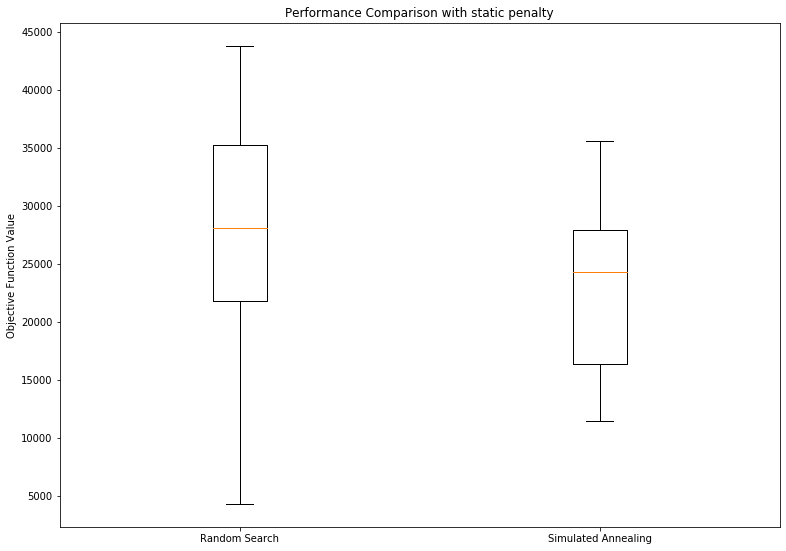

In [19]:
data_rs = [x[1] for x in rs_results]
data_sa = [x[1] for x in sa_results]

data = [data_rs, data_sa]
labels = ["Random Search", "Simulated Annealing"]

fig = plt.figure(figsize =(10, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
plt.title('Performance Comparison with static penalty')
plt.ylabel('Objective Function Value')

# Creating plot
bp = ax.boxplot(data, labels=labels)


# show plot
plt.show()

In [20]:
eval_report(data_rs, data_sa)

Statistically Analysis:
With Static penalty

Mean of Random Search: 26556.908367804514
Mean of Simulated Annealing: 22531.610308357023

Mean of Random Search: 28114.105642182098
Mean of Simulated Annealing: 24252.08551778939

Standard Deviation of Random Search: 10598.978066208032
Standard Deviation of Simulated Annealing: 7276.121078300028

Wilcoxon Signed-Rank Test:
Test Statistic: 82.0
P-value: 0.2442695329700293
There is no significant difference between the algorithms.


#### With Death penalty

In [21]:
def rs_death_wrapper(seed, function=f, constraints=constraints, bounds=bounds):
    return optimization_run(function, constraints, 
                            bounds, "rs", "death", 
                            10000, minimize=True,
                            seed=seed
                           )

In [22]:
def sa_death_wrapper(seed, function=f, constraints=constraints, bounds=bounds):
    return optimization_run(function, constraints, 
                            bounds, "sa", "death",
                            10000, 1000, 0.01, 1.5, 
                            seed=seed
                           )

In [23]:
rs_d_results, sa_d_results =  optimization_eval(rs_death_wrapper, sa_death_wrapper, 21)

Comparison of best solutions: 

Iteration 1, Seed - 15796, 
 Best solution from:
 Random Search -       52847.176724968114 
 Simulated Annealing - 37450.92099600154

Iteration 2, Seed - 861, 
 Best solution from:
 Random Search -       65850.73389683981 
 Simulated Annealing - 36938.8268391372

Iteration 3, Seed - 76821, 
 Best solution from:
 Random Search -       54540.64058866362 
 Simulated Annealing - 44297.40479913803

Iteration 4, Seed - 54887, 
 Best solution from:
 Random Search -       39277.929053770975 
 Simulated Annealing - 52048.94399077978

Iteration 5, Seed - 6266, 
 Best solution from:
 Random Search -       50573.94178641172 
 Simulated Annealing - 58501.93001364604

Iteration 6, Seed - 82387, 
 Best solution from:
 Random Search -       55245.6852371477 
 Simulated Annealing - 35493.981613520365

Iteration 7, Seed - 37195, 
 Best solution from:
 Random Search -       50965.113742296366 
 Simulated Annealing - 35507.02983706356

Iteration 8, Seed - 87499, 
 Best solu

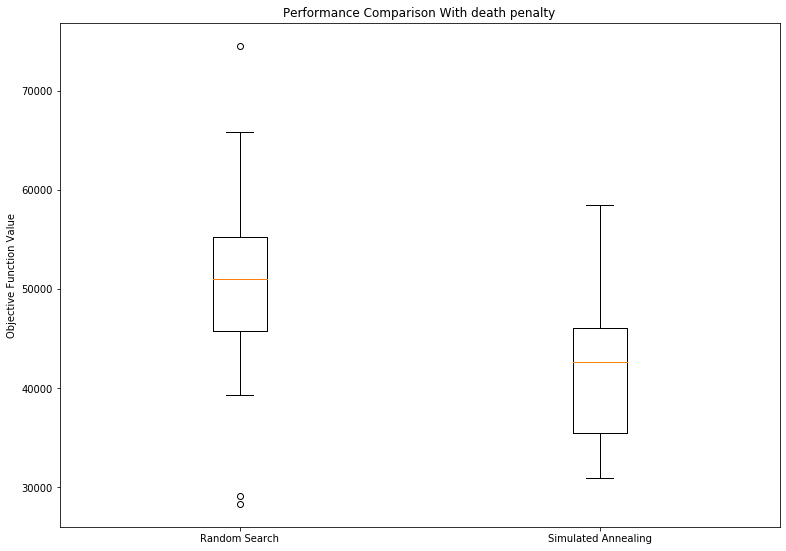

In [24]:
data_d_rs = [x[1] for x in rs_d_results]
data_d_sa = [x[1] for x in sa_d_results]

data_d = [data_d_rs, data_d_sa]
labels_d = ["Random Search", "Simulated Annealing"]

fig1 = plt.figure(figsize =(10, 7))

# Creating axes instance
ax1 = fig1.add_axes([0, 0, 1, 1])
plt.title('Performance Comparison With death penalty')
plt.ylabel('Objective Function Value')

# Creating plot
bp1 = ax1.boxplot(data_d, labels=labels_d)


# show plot
plt.show()

In [25]:
eval_report(data_d_rs, data_d_sa)

Statistically Analysis:
With Static penalty

Mean of Random Search: 50562.9927870985
Mean of Simulated Annealing: 41308.90668130748

Mean of Random Search: 50965.113742296366
Mean of Simulated Annealing: 42622.703423226245

Standard Deviation of Random Search: 10608.563656612498
Standard Deviation of Simulated Annealing: 7293.98951127344

Wilcoxon Signed-Rank Test:
Test Statistic: 42.0
P-value: 0.010628323936509337
There is a significant difference between the algorithms.


---

# **Comments and Conclusion**

The p-value obtained from the Wilcoxon signed-rank test for comparing Random Search and Simulated Annealing was found to be **0.010628** with Death penalty.

As this p-value is below the commonly chosen significance level, alpha, of 0.05, **we reject the null hypothesis** and conclude that there is a statistically significant difference in the performance of the two algorithms. This provides evidence to support the assertion that one algorithm outperforms the other in the context of the tested optimization problem.

Random Search has greater variability about the mean compared to that of Simulated Annealing, indicating a greater range of outcomes. This difference in variability has implications for the robustness and stability of the algorithms under consideration.

From the box plot and calculated mean, median & SD it can be safely concluded that Simulated Annealing is the better optimization strategy for the given problem.



**In Conclusion:**

Clearly, Simulated Annealing is the better optimization technique in the given context.

Although it takes more time to run than Random Search, it is self-evident from the statistical analysis of the results that Simulated Annealing reaches the optimum more reliably and consistently than Random Search.

---
Comment on constraint handling techniques chosen:

With Death penalty, p-value is less than alpha and therefore we can reject the null hypothesis. However, with Static penalty, p-value is above alpha, while it is not conclusive in itself, from the complete statistical analysis, it is clear that Simulated Annealing is more stable with less variability.

#### NOTE: Something is not right, feasible space is too small, it's better to use static penalty and indeed it should give better results.
I have made some obvious mistakes here.